# Implementing Fast R-CNN, Faster R-CNN, Mask R-CNN and 100 layer tiramisu

## Imports 

In [134]:
import sys
import os
import importlib
import shutil
import numpy as np
import threading
import keras
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import selectivesearch
importlib.reload(selectivesearch)
from selectivesearch import get_selective_search_regions

import PIL

import utils
importlib.reload(utils)
from utils import *

import pascal_voc_reader
# importlib.reload(pascal_voc_reader)

from IPython.core.debugger import Tracer

%matplotlib inline

In [3]:
image_size = (500, 500)

## Pascal VOC

### Load data

In [151]:
data_path = './data/'

samples, classes_count, class_mapping = pascal_voc_reader.get_data(
    data_path)
if 'bg' not in classes_count:
    classes_count['bg'] = 0
    # Add the background class with index 0
    class_mapping = {k: v + 1 for k, v in class_mapping.items()}
    class_mapping['bg'] = 0

filenames = [sample['filepath'] for sample in samples]
# print(filenames)

Parsing annotation files
[Errno 2] No such file or directory: './data/VOC2012/ImageSets/Main/test.txt'


#### Review

In [3]:
class_mapping

{'aeroplane': 12,
 'bg': 0,
 'bicycle': 16,
 'bird': 3,
 'boat': 13,
 'bottle': 18,
 'bus': 20,
 'car': 5,
 'cat': 14,
 'chair': 7,
 'cow': 2,
 'diningtable': 6,
 'dog': 8,
 'horse': 10,
 'motorbike': 9,
 'person': 4,
 'pottedplant': 19,
 'sheep': 15,
 'sofa': 17,
 'train': 1,
 'tvmonitor': 11}

In [4]:
classes_count

{'aeroplane': 1002,
 'bg': 0,
 'bicycle': 837,
 'bird': 1271,
 'boat': 1059,
 'bottle': 1561,
 'bus': 685,
 'car': 2492,
 'cat': 1277,
 'chair': 3056,
 'cow': 771,
 'diningtable': 800,
 'dog': 1598,
 'horse': 803,
 'motorbike': 801,
 'person': 17401,
 'pottedplant': 1202,
 'sheep': 1084,
 'sofa': 841,
 'train': 704,
 'tvmonitor': 893}

In [13]:
len(samples)

17125

In [14]:
samples

[{'bboxes': [{'class': 'train', 'x1': 86, 'x2': 421, 'y1': 113, 'y2': 227}],
  'filepath': './data/VOC2012/JPEGImages/2010_000984.jpg',
  'height': 366,
  'imageset': 'trainval',
  'width': 500},
 {'bboxes': [{'class': 'cow', 'x1': 106, 'x2': 215, 'y1': 333, 'y2': 401}],
  'filepath': './data/VOC2012/JPEGImages/2009_003218.jpg',
  'height': 500,
  'imageset': 'trainval',
  'width': 500},
 {'bboxes': [{'class': 'bird', 'x1': 244, 'x2': 327, 'y1': 67, 'y2': 150}],
  'filepath': './data/VOC2012/JPEGImages/2008_002624.jpg',
  'height': 375,
  'imageset': 'trainval',
  'width': 500},
 {'bboxes': [{'class': 'person', 'x1': 75, 'x2': 396, 'y1': 95, 'y2': 375}],
  'filepath': './data/VOC2012/JPEGImages/2008_000316.jpg',
  'height': 375,
  'imageset': 'trainval',
  'width': 500},
 {'bboxes': [{'class': 'car', 'x1': 143, 'x2': 189, 'y1': 103, 'y2': 118},
   {'class': 'car', 'x1': 196, 'x2': 244, 'y1': 102, 'y2': 116},
   {'class': 'car', 'x1': 260, 'x2': 306, 'y1': 102, 'y2': 117},
   {'class': 

#### Ground Truth bounding boxes

In [152]:
input_boxes = [sample['bboxes'] for sample in samples]

truth_boxes = []
for boxes in input_boxes:
    sample_boxes = []
    for box in boxes:
        x1 = box['x1']
        y1 = box['y1']
        w = box['x2'] - x1
        h = box['y2'] - y1

        class_name = box['class']
        class_index = class_mapping[class_name]

        processed_box = [x1, y1, w, h, class_index]
#         processed_box = {'class': class_mapping[class_name],
#                          'x1': x1, 'y1': y1, 'w': w, 'h': h}
        sample_boxes.append(processed_box)

    truth_boxes.append(sample_boxes)

In [16]:
truth_boxes

[[[86, 113, 335, 114, 1]],
 [[106, 333, 109, 68, 2]],
 [[244, 67, 83, 83, 3]],
 [[75, 95, 321, 280, 4]],
 [[143, 103, 46, 15, 5],
  [196, 102, 48, 14, 5],
  [260, 102, 46, 15, 5],
  [306, 102, 34, 13, 5],
  [325, 103, 125, 44, 5],
  [1, 105, 95, 187, 4]],
 [[1, 1, 271, 499, 1], [205, 143, 102, 151, 4], [142, 156, 89, 138, 4]],
 [[206, 316, 35, 111, 4],
  [171, 305, 36, 121, 4],
  [153, 321, 26, 83, 4],
  [246, 312, 40, 121, 4]],
 [[1, 200, 435, 175, 6], [62, 1, 436, 310, 4], [29, 1, 97, 187, 7]],
 [[139, 99, 56, 85, 4]],
 [[15, 9, 314, 227, 8]],
 [[1, 1, 110, 59, 5], [77, 17, 299, 383, 9]],
 [[189, 73, 64, 156, 4], [149, 119, 176, 167, 10]],
 [[144, 134, 104, 240, 4], [247, 84, 118, 196, 4]],
 [[399, 20, 23, 19, 5],
  [348, 73, 49, 32, 7],
  [242, 78, 32, 58, 7],
  [199, 86, 42, 76, 7],
  [154, 104, 41, 92, 7],
  [80, 129, 66, 94, 7],
  [3, 164, 48, 132, 7],
  [394, 92, 90, 95, 7],
  [394, 111, 96, 100, 7],
  [370, 132, 114, 143, 7],
  [330, 171, 153, 196, 7],
  [279, 248, 193, 126, 7]

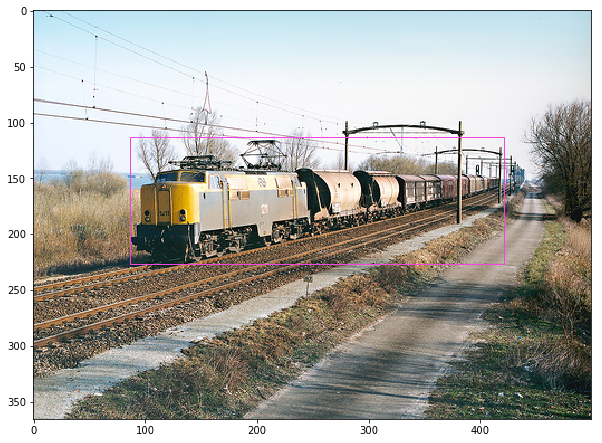

In [85]:
img_index = 0
original_image = np.asarray(PIL.Image.open(
    filenames[img_index]), dtype='uint8')
display_image_regions(original_image, truth_boxes[img_index])

##### Resize truth boxes

In [86]:
def get_image_size(filename):
    ''' Load an image and return its size. '''
    return PIL.Image.open(filename).size


def resize_bbox(bbox, original_size, new_size):
    ''' Resize a single bbox. '''
    output_width, output_height = new_size
    img_width, img_height = original_size

    # how much to scale each bbox dimension
    img_scale_x = output_width / img_width
    img_scale_y = output_height / img_height

    # Scale bbox
    bbox[0] *= img_scale_x
    bbox[1] *= img_scale_y
    bbox[2] *= img_scale_x
    bbox[3] *= img_scale_y

    return bbox


def resize_bboxes(bboxes, image_filenames, new_size):
    ''' Resize all bboxes. '''
    # For all images
    for index, filename in enumerate(image_filenames):
        image_bboxes = bboxes[index]
        image_size = get_image_size(filename)
        # There might be multiple bboxes per image
        for bbox in image_bboxes:
            resize_bbox(bbox, image_size, new_size)
    return bboxes


resized_truth_boxes = resize_bboxes(truth_boxes, filenames, image_size)

In [87]:
resized_truth_boxes

[[[86.0, 154.37158469945354, 335.0, 155.7377049180328, 1]],
 [[106.0, 333.0, 109.0, 68.0, 2]],
 [[244.0, 89.33333333333333, 83.0, 110.66666666666666, 3]],
 [[75.0, 126.66666666666666, 321.0, 373.3333333333333, 4]],
 [[143.0, 176.36986301369862, 46.0, 25.684931506849313, 5],
  [196.0, 174.65753424657535, 48.0, 23.972602739726028, 5],
  [260.0, 174.65753424657535, 46.0, 25.684931506849313, 5],
  [306.0, 174.65753424657535, 34.0, 22.26027397260274, 5],
  [325.0, 176.36986301369862, 125.0, 75.34246575342466, 5],
  [1.0, 179.7945205479452, 95.0, 320.20547945205476, 4]],
 [[1.3333333333333333, 1.0, 361.3333333333333, 499.0, 1],
  [273.3333333333333, 143.0, 136.0, 151.0, 4],
  [189.33333333333331, 156.0, 118.66666666666666, 138.0, 4]],
 [[274.66666666666663, 316.0, 46.666666666666664, 111.0, 4],
  [228.0, 305.0, 48.0, 121.0, 4],
  [204.0, 321.0, 34.666666666666664, 83.0, 4],
  [328.0, 312.0, 53.33333333333333, 121.0, 4]],
 [[1.0, 266.66666666666663, 435.0, 233.33333333333331, 6],
  [62.0, 1.3

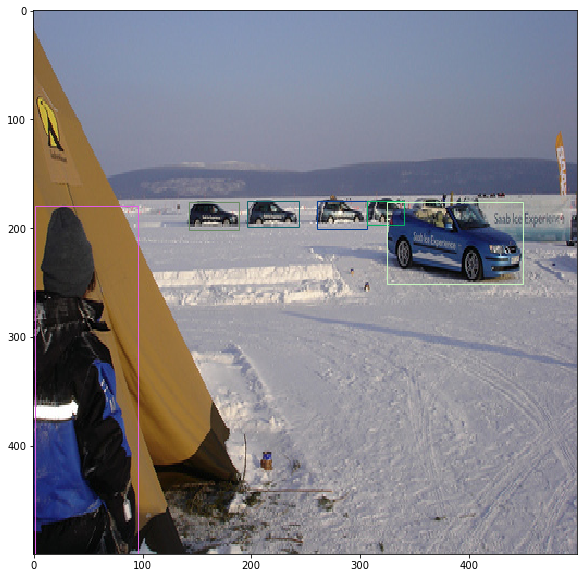

In [89]:
img_index = 4
display_image_regions(all_samples[img_index], resized_truth_boxes[img_index])

In [90]:
filename = 'voc_gt_boxes_{}x{}.bcolz'.format(
    image_size[0], image_size[1])

save_array(filename, resized_truth_boxes)

In [ ]:
all_regions = np.asarray(resized_truth_boxes)

#### Load images

In [10]:
def load_image(filename, size=(500, 500)):
    ''' Load an image, resized it and convert it to a np array. '''
    image = PIL.Image.open(filename)
    image = image.resize((size[0], size[1]))
    return np.array(image, dtype=np.uint8)

In [11]:
images = np.zeros((len(filenames), 500, 500, 3), dtype=np.uint8)
for index, filename in enumerate(filenames):
    images[index] = load_image(filename)

In [13]:
image_size = (500, 500)
all_samples = images
samples_filename = 'voc_images_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
save_array(samples_filename, all_samples)

#### Check if proposed regions have intersection with truth box

#### Check if ROIs have intersections with ground truth boxes

In [157]:
def get_augumented_regions_proposals(region):
    ''' Find a bunch of augumented ROI proposals by adjusting some of the region
    params. 
    Args:
        region: A tuple with (x, y, w, h, class_id) defining a region.
    '''
    x, y, w, h, class_id = region
    augumented_regions = []

    # Spatial scale is the min number of pixels to shift the region
    # to actually move to the next convolutional activation.
    # This should be mupltiples of 1 / spatial_scale from ROI Pooling
    # E.g. for VGG16 the spatial scale is 1/16, so here we use 16, 32.
    spatial_scales = (32, 16)
    for spatial_scale in spatial_scales:
        # Augumenting only a single parameter
        augumented_regions.extend([
            [x + spatial_scale, y, w, h, class_id],
            [x, y + spatial_scale, w, h, class_id],
            [x, y, w + spatial_scale, h, class_id],
            [x, y, w, h + spatial_scale, class_id],

            [x - spatial_scale, y, w, h, class_id],
            [x, y - spatial_scale, w, h, class_id],
            [x, y, w - spatial_scale, h, class_id],
            [x, y, w, h - spatial_scale, class_id]])

        # augument combinations of two params
        for spatial_scale2 in spatial_scales:
            augumented_regions.extend([
                [x + spatial_scale, y + spatial_scale2, w, h, class_id],
                [x + spatial_scale, y, w + spatial_scale2, h, class_id],
                [x + spatial_scale, y, w, h + spatial_scale2, class_id],
                [x + spatial_scale, y - spatial_scale2, w, h, class_id],
                [x + spatial_scale, y, w - spatial_scale2, h, class_id],
                [x + spatial_scale, y, w, h - spatial_scale2, class_id],

                [x - spatial_scale, y + spatial_scale2, w, h, class_id],
                [x - spatial_scale, y, w + spatial_scale2, h, class_id],
                [x - spatial_scale, y, w, h + spatial_scale2, class_id],
                [x - spatial_scale, y - spatial_scale2, w, h, class_id],
                [x - spatial_scale, y, w - spatial_scale2, h, class_id],
                [x - spatial_scale, y, w, h - spatial_scale2, class_id],

                [x, y + spatial_scale, w + spatial_scale2, h, class_id],
                [x, y + spatial_scale, w, h + spatial_scale2, class_id],
                [x, y + spatial_scale, w - spatial_scale2, h, class_id],
                [x, y + spatial_scale, w, h - spatial_scale2, class_id],

                [x, y - spatial_scale, w + spatial_scale2, h, class_id],
                [x, y - spatial_scale, w, h + spatial_scale2, class_id],
                [x, y - spatial_scale, w - spatial_scale2, h, class_id],
                [x, y - spatial_scale, w, h - spatial_scale2, class_id],

                [x, y, w + spatial_scale, h + spatial_scale2, class_id],
                [x, y, w + spatial_scale, h - spatial_scale2, class_id],

                [x, y, w - spatial_scale, h + spatial_scale2, class_id],
                [x, y, w - spatial_scale, h - spatial_scale2, class_id],
            ])
    return augumented_regions


def augument_regions(regions, min_number, gt_boxes, min_iou, max_iou=None):
    ''' Try random petrubations to augument ROIs. As we need a minimum number of
    positive and negative rois. 
    Args:
        regions: The regions to augument.
        min_number: How many regions should we have. So we don't waste time 
            looking for more than needed.
        gt_boxes: the ground truth boxes.
        min_iou: The minumum Intersection over Union a good augumented region 
            should have with at least 1 ground truth box.
        max_iou: The max IOU an augumented region should have.
    '''
    good_regions = []
    # Augument each good region found so far (proposed by Selective search,
    # or other algo)
    augumented_regions = []
    for region in regions:
        augumented_regions.extend(get_augumented_regions_proposals(region))
        
    # Shuffle the augumented regions so that each region has a chance to be 
    # augumented.
    shuffle_mask = np.random.permutation(len(augumented_regions))
    augumented_regions = np.asarray(augumented_regions)[shuffle_mask]
        
    # We have a bunch of possible augumented regions,
    # let's test to see if they have proper IoU.
    for aug_region in augumented_regions:
        for gt_box in gt_boxes:
            iou_computed = iou(gt_box, aug_region)
            if iou_computed >= min_iou and iou_computed < max_iou:
                # which class is this region a sample for.
                good_regions.append(aug_region)
                # This region is good, dont test it any more
                break
                
        # If we got enough regions, exit to save time        
        if len(good_regions) >= min_number:
            return good_regions

    return good_regions

In [170]:
%%time
samples_count = []
# Min and max ious for a box to be considered positive/negative
min_positive_iou = 0.5
max_positive_iou = 1.1  # it shouldn't really go above 1 anyways

min_negative_iou = 0.1
max_negative_iou = 0.5

# We will store the positive and negative regions for each image in these
all_positive_regions = []
all_negative_regions = []

for image_boxes, regions in zip(truth_boxes, all_regions):
    positive_samples = []
    negative_samples = []
    for region in regions:
        for truth_box in image_boxes:
            iou_computed = iou(truth_box, region)
            if iou_computed >= min_positive_iou:
                region = region + (truth_box[4], )
                positive_samples.append(region)
                break
            elif (iou_computed >= min_negative_iou
                  and iou_computed < max_negative_iou):
                region = region + (truth_box[4], )
                negative_samples.append(region)
                break

    # augument positive samples if not enough
    min_positive_samples = 16 * 2
    if (len(positive_samples) > 0
            and len(positive_samples) < min_positive_samples):
        addition_samples_needed = min_positive_samples - len(positive_samples)
        augumented_regions = augument_regions(
            positive_samples, addition_samples_needed,
            image_boxes,
            min_iou=min_positive_iou, max_iou=max_positive_iou)
        positive_samples.extend(augumented_regions)

    min_negative_samples = 48 * 2
    if (len(negative_samples) > 0
            and len(negative_samples) < min_negative_samples):
        addition_samples_needed = min_negative_samples - len(negative_samples)
        augumented_regions = augument_regions(
            negative_samples, addition_samples_needed,
            image_boxes,
            min_iou=min_negative_iou, max_iou=max_negative_iou)
        negative_samples.extend(augumented_regions)

    all_positive_regions.append(positive_samples)
    all_negative_regions.append(negative_samples)

    samples_count.append((len(positive_samples), len(negative_samples)))

CPU times: user 2min 48s, sys: 84 ms, total: 2min 48s
Wall time: 2min 48s


In [159]:
samples_count = np.array(samples_count)

In [165]:
len(samples_count)

14410

In [148]:
# do we have enough positive and negative samples for each image
enough_samples_mask = (samples_count[:, 0] >= 16) & (samples_count[:, 1] >= 48)
print('Images with enough positive and negative rois:',
      np.sum(enough_samples_mask))

Images with enough positive and negative rois: 10


Extract the positive and negative regions that are enough.

In [85]:
all_positive_regions = np.asarray(all_positive_regions)
all_negative_regions = np.asarray(all_negative_regions)

In [86]:
# save the mask
filename = 'voc_enough_samples_mask_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
save_array(filename, enough_samples_mask)

# save positive and negative rois
filename = 'voc_positive_rois_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
save_array(filename, all_positive_regions)

filename = 'voc_negative_rois_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
save_array(filename, all_negative_regions)

#### Split into train-valid set

In [107]:
num_samples = np.sum(enough_samples_mask)
# 10% validation set
num_valid_samples = int(num_samples / 10)
num_train_samples = num_samples - num_valid_samples

random_indexes = np.random.permutation(num_samples)
valid_indexes = random_indexes[:num_valid_samples]
train_indexes = random_indexes[num_valid_samples:]
save_array('voc_valid_indexes.bcolz', valid_indexes)
save_array('voc_train_indexes.bcolz', train_indexes)

#### Load precomputed data

In [108]:
filename = 'voc_enough_samples_mask_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
enough_samples_mask = load_array(filename)

valid_indexes = load_array('voc_valid_indexes.bcolz')
train_indexes = load_array('voc_train_indexes.bcolz')

In [153]:
samples_filename = 'voc_images_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
all_samples = load_array(samples_filename)

all_samples = all_samples[enough_samples_mask]
train_samples = all_samples[train_indexes]
valid_samples = all_samples[valid_indexes]

In [154]:
filename = 'voc_gt_boxes_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
truth_boxes = load_array(filename)

truth_boxes = truth_boxes[enough_samples_mask]
train_gt_boxes = truth_boxes[train_indexes]
valid_gt_boxes = truth_boxes[valid_indexes]

In [167]:
filename = 'voc_rois_{}x{}_scale_750.bcolz'.format(
    image_size[0], image_size[1])
all_regions = load_array(filename)

all_regions = all_regions[enough_samples_mask]
train_rois = np.asarray(all_regions)[train_indexes]
valid_rois = np.asarray(all_regions)[valid_indexes]

In [118]:
# load positive rois
filename = 'voc_positive_rois_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
all_positive_regions = load_array(filename)

all_positive_regions = all_positive_regions[enough_samples_mask]
train_positive_rois = all_positive_regions[train_indexes]
valid_positive_rois = all_positive_regions[valid_indexes]

# load negative rois
filename = 'voc_negative_rois_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
all_negative_regions = load_array(filename)

all_negative_regions = all_negative_regions[enough_samples_mask]
train_negative_rois = all_negative_regions[train_indexes]
valid_negative_rois = all_negative_regions[valid_indexes]

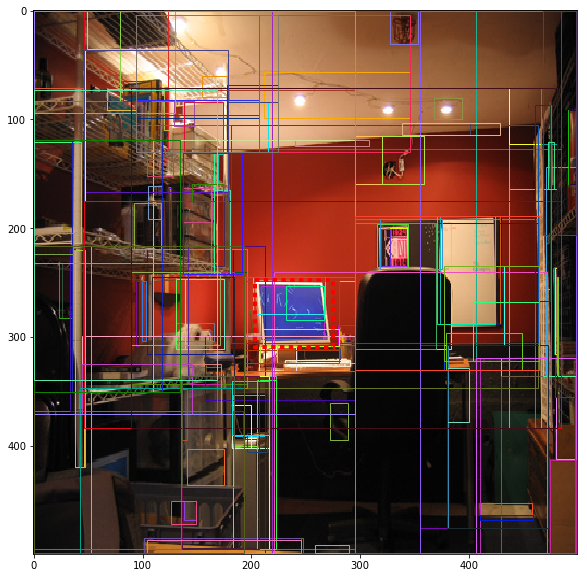

In [141]:
img_index = 1
display_image_regions(valid_samples[img_index], valid_rois[img_index],
                      valid_gt_boxes[img_index][0])

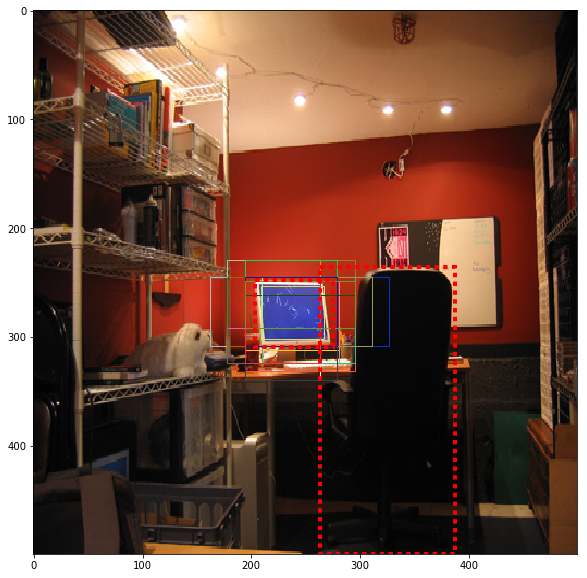

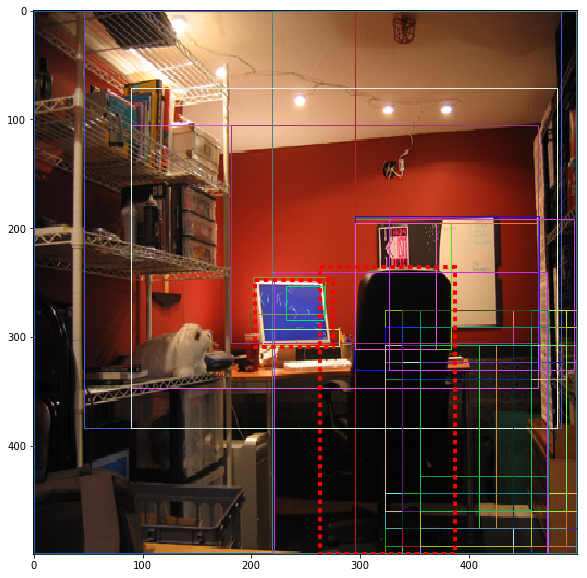

In [142]:
img_index = 1
display_image_regions(valid_samples[img_index], valid_positive_rois[img_index],
                      valid_gt_boxes[img_index])

display_image_regions(valid_samples[img_index], valid_negative_rois[img_index],
                      valid_gt_boxes[img_index])

# Fishing

## Load Data

In [2]:
image_size = (360, 640)

In [3]:
# Load data
data_gen = get_batch('../fishing/data/train', image_size)
filenames = data_gen.filenames

Found 3212 images belonging to 8 classes.


In [32]:
all_samples = get_all_generator_samples(data_gen)
samples_filename = 'test_samples_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
save_array(samples_filename, all_samples)

In [4]:
samples_filename = 'train_samples_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
all_samples = load_array(samples_filename)
all_samples.shape

(3212, 360, 640, 3)

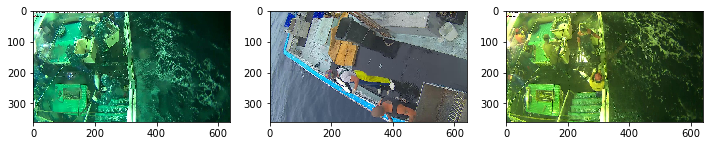

In [5]:
plot_images(all_samples[:3])

## Selective Search

In [23]:
def get_ss_regions(i):
    return get_selective_search_regions(all_samples[i].astype('uint8'),
                                        scale=750)

In [22]:
% % time
img = all_samples[3000].astype('uint8')
regions = get_selective_search_regions(img, scale=750)
print(len(regions))
# display_image_regions(img, regions, figsize=(12, 12))

131
CPU times: user 2.39 s, sys: 16 ms, total: 2.4 s
Wall time: 2.4 s


In [ ]:
% % time
regions = []
for i in range(10):
    regions.append(get_selective_search_regions(all_samples[i].astype('uint8'),
                                                scale=50))

It is quite slow so let's see if we can speed it up with multithreading.

#### SS with multithreading


Test a few different number of workers to figure out what works best.

In [ ]:
% % time
num_samples = 50  # len(all_samples)
regions = []
with ThreadPoolExecutor(max_workers=4) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

2m 1s

In [120]:
% % time
num_samples = 50  # len(all_samples)
regions = []
with ThreadPoolExecutor(max_workers=8) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

CPU times: user 3min 53s, sys: 7.54 s, total: 4min 1s
Wall time: 2min 7s


In [121]:
% % time
num_samples = 50  # len(all_samples)
regions = []
with ThreadPoolExecutor(max_workers=16) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

CPU times: user 4min 1s, sys: 9.51 s, total: 4min 11s
Wall time: 2min 11s


In [122]:
% % time
num_samples = 50  # len(all_samples)
regions = []
with ThreadPoolExecutor(max_workers=32) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

CPU times: user 4min 10s, sys: 10.4 s, total: 4min 21s
Wall time: 2min 15s


#### SS with multiprocessing

In [128]:
num_samples = 50  # len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=2) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

1m 23.8s

In [123]:
num_samples = 50  # len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=4) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

1m 10.7s

In [124]:
num_samples = 50  # len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=8) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

 1m 11.8s

In [125]:
num_samples = 50  # len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=16) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

1m 14.9s

In [126]:
num_samples = 50  # len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=32) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

1m 18.2s

So it seems miltiprocessing with 4 processes works best: the P2 istance this is running on has 4 virtual CPUs, apparently with a single thread on each.

#### Compute regions for all images

##### Validation set regions

In [10]:
# Load data
data_gen = get_batch('../fishing/data/valid', image_size)
filenames = data_gen.filenames

samples_filename = 'valid_samples_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
all_samples = load_array(samples_filename)
all_samples.shape

Found 547 images belonging to 8 classes.


(547, 360, 640, 3)

In [25]:
num_samples = len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=4) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

save_array('valid_regions.bcolz', list(regions))

##### Train set regions

In [197]:
# Load data
data_gen = get_batch('../fishing/data/train', image_size)
filenames = data_gen.filenames

samples_filename = 'train_samples_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
all_samples = load_array(samples_filename)
all_samples.shape

Found 3212 images belonging to 8 classes.


(3212, 360, 640, 3)

In [ ]:
num_samples = len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=4) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

save_array('valid_regions.bcolz', list(regions))

##### Test set regions

In [35]:
# Load data
data_gen = get_batch('../fishing/data/test', image_size)
filenames = data_gen.filenames

samples_filename = 'test_samples_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
all_samples = load_array(samples_filename)
all_samples.shape

Found 1000 images belonging to 1 classes.


(1000, 360, 640, 3)

In [36]:
num_samples = len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=4) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

save_array('test_regions.bcolz', list(regions))

##### Load regions

In [26]:
def load_regions(filename):
    regions = load_array(filename)
    # remove the filename from the array
    return [list(region[1]) for region in regions]


train_regions = load_regions('train_regions.bcolz')
len(train_regions)

17125

#### Load groundtruth boxes

In [93]:
save_dir = '../fishing/intermediate/bboxes/'
train_truth = load_array(os.path.join(
    save_dir, 'train_bbox_prepared_{}x{}'.format(image_size[0], image_size[1])))
valid_truth = load_array(os.path.join(
    save_dir, 'valid_bbox_prepared_{}x{}'.format(image_size[0], image_size[1])))
train_truth.shape, valid_truth.shape

((3212, 4), (547, 4))

In [94]:
# the truth bboxes are in format (x,y,h,w) and we want them in (x,y,w,h)
train_truth[:, [2, 3]] = train_truth[:, [3, 2]]
valid_truth[:, [2, 3]] = valid_truth[:, [3, 2]]

In [ ]:
img_index = 100
img = all_samples[img_index].astype('uint8')
regions = train_regions[img_index]
truth_box = train_truth[img_index]

display_image_regions(
    img, regions, ground_truth_box=truth_box, figsize=(12, 12))
train_bboxes[100]

#### Do proposed regions have intersections with the groundtruths

Let's calculate how many of our ROIs have IOUs >= 0.5 and in [0.1, 0.5)


In [27]:
# Intersection over Union metric
def iou(box1, box2):
    ''' Computes the intersection over union for two boxes.
    '''
    epsilon = 1e-7
    x1, y1, w1, h1 = box1[:4]
    x2, y2, w2, h2 = box2[:4]

    intersection_x1 = max(x1, x2)
    intersection_y1 = max(y1, y2)
    intersection_x2 = min(x1 + w1, x2 + w2)
    intersection_y2 = min(y1 + h1, y2 + h2)

    # The area can't be less than 0
    intersection_area = (max(0, intersection_x2 - intersection_x1)
                         * max(0, intersection_y2 - intersection_y1))

    true_area = abs(h1 * w1)
    pred_area = abs(h2 * w2)
    iou = intersection_area / (true_area + pred_area
                               - intersection_area + epsilon)

    return iou


# Some tests
iou_computed = iou(
    [0, 1, 12, 10],
    [12, 11, 6, 6])
np.testing.assert_array_almost_equal(iou_computed, 0)

iou_computed = iou(
    [0, 1, 10, 9],
    [9, 9, 5, 5])
np.testing.assert_array_almost_equal(iou_computed, 1 / 114)

iou_computed = iou(
    [10, 11, 6, 5],
    [12, 13, 1, 2])
np.testing.assert_array_almost_equal(iou_computed, 2 / 30)

iou_computed = iou(
    [283.5, 190.5, 26., 65.5],
    [479, 244, 22, 35])
np.testing.assert_array_almost_equal(iou_computed, 0)

iou_computed = iou(
    [283.5, 190.5, 26., 65.5],
    [437, 133, 29, 33])
np.testing.assert_array_almost_equal(iou_computed, 0)

In [210]:
max_ious = []
for truth, regions in zip(train_truth, train_regions):
    positive_samples = []
    negative_samples = []
    max_iou = 0
    min_iou = 0
    for region in regions:
        iou_computed = iou(truth_box, region)
        if iou_computed >= 0.3:
            positive_samples.append(region)
        elif iou_computed >= 0.05 and iou_computed < 0.3:
            negative_samples.append(region)
        max_iou = max(iou_computed, max_iou)
    max_ious.append(max_iou)
#     print(len(positive_samples), len(negative_samples))

In [215]:
np.sum(np.array(max_ious) >= 0.5)

384

In [ ]:
display_image_regions(img, positive_samples,
                      ground_truth_box=truth_box, figsize=(12, 12))

# Fast RCNN

## Prepare batch

In [178]:
len(valid_samples)

1712

In [185]:
len(valid_samples[1712:1713])

0

In [17]:
# The indexes are lists, so they would be mutable
train_index = [0]
valid_index = [0]


def get_batch(source='train', batch_size=128, images_per_batch=2):
    ''' '''
    if source is 'train':
        index = train_index
        images = train_samples
        gt_boxes = train_gt_boxes
        rois = train_rois
    elif source is 'valid':
        index = train_index
        images = train_samples
        gt_boxes = train_gt_boxes
        rois = train_rois
    # If we looped around
    if index[0] + images_per_batch > len(images):
        index[0] = 0

    batch_images = images[index[0]:index[0] + images_per_batch]
    batch_gt_boxes = gt_boxes[index[0]:index[0] + images_per_batch]
    batch_rois = rois[index[0]:index[0] + images_per_batch]

    index[0] += images_per_batch
    # We need to have
    for i in range()

    return batch


result = get_batch()
print(len(result))
result

3


[[{'class': 1, 'h': 114, 'w': 335, 'x1': 86, 'y1': 113}],
 [{'class': 2, 'h': 68, 'w': 109, 'x1': 106, 'y1': 333}],
 [{'class': 3, 'h': 83, 'w': 83, 'x1': 244, 'y1': 67}]]

## ROI Pooling

In [194]:
import torch
import torchvision
from torch.autograd import Variable

In [186]:
test_input = Variable(torch.range(0, 1759).view(1, 2, 22, 40)).cuda()
test_rois = Variable(torch.FloatTensor([[0, 90., 110., 10., 60.]]))

In [188]:
class ROIPooling(torch.nn.Module):
    def __init__(self, size=(7, 7), spatial_scale=(1. / 16.)):
        ''' 
        size: The output size for each region of interest.
        spatial_scale: How much to scale ROI dimensions before slicing
            activations map.
        '''
        super(ROIPooling, self).__init__()
        assert (len(size) == 2), 'ROI Pooling expects a 2d output size.'
        self.size = size
        self.spatial_scale = spatial_scale

    def forward(self, x, all_rois):
        ''' Do ROI pooling over the convolutional activations maps. 
        Each ROI specifies a region of convolutional features to resize to a 
        predefined size (usually 7x7) using Max Pool.

        Args:
            x: feature activations map: sample_index x channels x width x height
            all_rois: Region tensor. Each region is (sample_index, x, y, w, h)
        '''
        assert (len(x.size()) == 4), ('ROI Pooling expects feature maps as '
                                      + '4d Tensor.')
        assert (all_rois.size(1) == 5), (
            'ROI Pooling expects each ROIs to be like: (sample, x, y, h, w).')

        # The output will be sized:
        # (number of rois, conv channels, roi output as a vector)
        output_size = (all_rois.size()[0], x.size(
            1), self.size[0] * self.size[1])
        outputs = Variable(torch.zeros(output_size).cuda())
        for roi_index, roi in enumerate(all_rois):
            img_index = int(roi.data[0])
            roi_scaled = roi.data.float() * self.spatial_scale
            _, x1, y1, w, h = roi_scaled
            x2, y2 = x1 + w, y1 + h
            # Make sure minimal slice size is 1 across x and y
            x2 = max(x2, x1 + 1)
            y2 = max(y2, y1 + 1)
            x1, y1, x2, y2 = round(x1), round(y1), round(x2), round(y2)

            roi_activations = x[img_index, :, x1:x2, y1:y2]
            output = torch.nn.modules.pooling.AdaptiveMaxPool2d(self.size)(
                roi_activations)
            outputs[roi_index] = output.view(-1, self.size[0] * self.size[1])

        return outputs

In [189]:
output = ROIPooling((7, 7)).forward(test_input, test_rois)

# 2x1x4 tensor
test_output = np.asarray(
    [[[247., 248., 248., 249., 249.0, 250., 250.] * 7,
      [1127., 1128., 1128., 1129., 1129., 1130., 1130.] * 7]],
    dtype=float)

assert np.isclose(
    output.data.cpu().numpy(), test_output).all()

In [ ]:
torchvision.models.vgg16_bn